In [173]:
#with 
import dill
mesh = dill.load(open("meshes_f2/mdim0_noise_100k.pkl", 'rb'))
#mesh = dill.load(open("meshes/hopper0_iden.pkl", 'rb'))

In [174]:
from scipy.sparse import lil_matrix
import matplotlib.pyplot as plt
import numpy as np
import matplotlib 
T = lil_matrix((len(mesh), len(mesh)))
all_states = []

T[0,0] = 1
for box in mesh.values():
    all_states.append(np.asarray(box.state))

    for trans_id in box.trans_list:
        T[box.id, trans_id] += 1/len(box.trans_list)
        

Text(0.5, 1.05, 'State Transition Sparsity Pattern ')

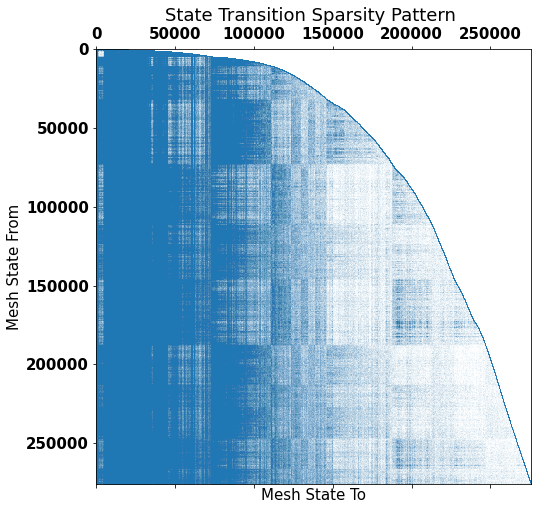

In [185]:
#plt.spy(T, markersize=4, figsize=(15,20))
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}

matplotlib.rc('font', **font)


fig, ax = plt.subplots(1, figsize=(10,8))
plt.spy(T, markersize=.05, alpha=.1, aspect='equal')
plt.xlabel('Mesh State To')
plt.ylabel('Mesh State From')
plt.title("State Transition Sparsity Pattern ")
#plt.ticklabel_format(style='scientific', scilimits=(-5,1))


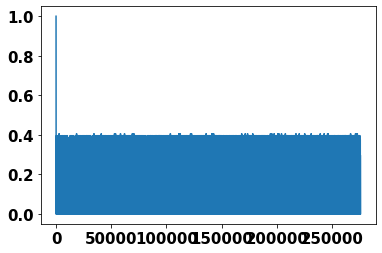

In [186]:
T = T.tocsc()

fail = T[:,0].todense()

plt.plot(fail);

xl = []
yl = []
vl = []
T = T.tocoo()
for i,j,v in zip(T.row, T.col, T.data):
        xl.append(i)
        yl.append(j)
        vl.append(v)

xm = np.array(xl)
ym = np.array(yl)
vm = np.array(vl)
from scipy.io import savemat
savemat("./meshes_f2/mdim_100k.mat", {'states_m':np.stack(all_states),'im':xm+1,'jm':ym+1, 'vm':vm})

In [204]:
from scipy.sparse.linalg import eigs
import numpy as np

w, v = eigs(T.transpose())
print(w)

print(1/(1 - w[1]))

[ 1.        +0.j  0.99100059+0.j -0.37194302+0.j  0.37270227+0.j
  0.16763934+0.j  0.15649436+0.j]
(111.11845628431179+0j)


In [6]:
np.sum(T[:,0])

47.663366336633686

In [189]:
T = T.tocsc()

col_sums = []
for i in range(T.shape[1]):
    col_sums.append(np.sum(T[:,i]))
col_sums = sorted(col_sums)[:-1]

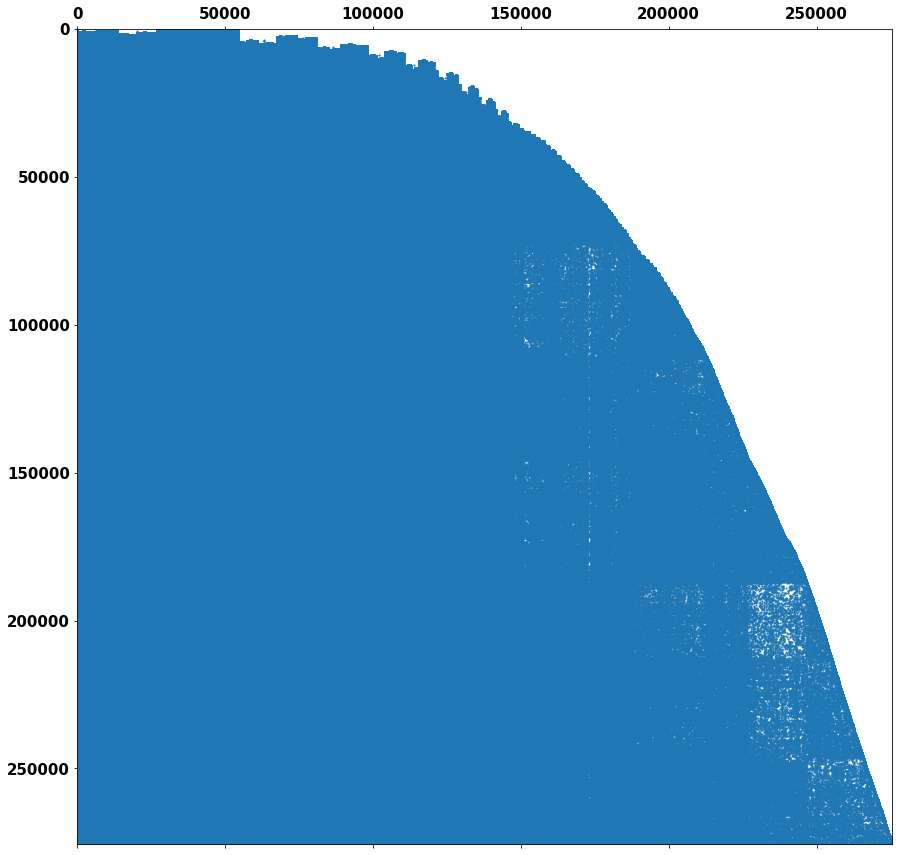

In [190]:
sorted_i = np.argsort(col_sums)
Tsort = T[:, sorted_i]
plt.figure(figsize=(15,15))
plt.spy(Tsort, markersize=1)

NameError: name 'x' is not defined

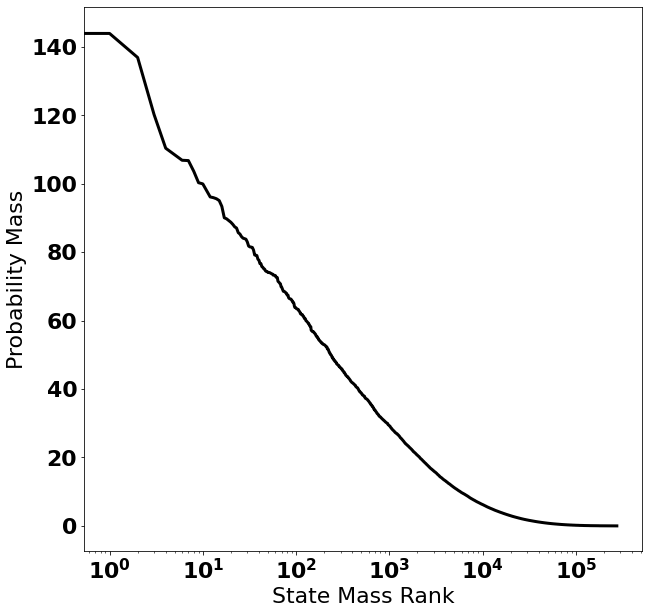

In [195]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)


plt.figure(figsize=(10,10))
plt.semilogx(sorted(col_sums,reverse=True), color='k', linewidth=3)
plt.xlabel('State Mass Rank')
plt.ylabel("Probability Mass")
plt.grid('both')

In [197]:
mass_total = sum(col_sums)
sum_so_far = 0
cum_sums = []

for s in col_sums[::-1]:
    sum_so_far += s
    cum_sums.append(sum_so_far)

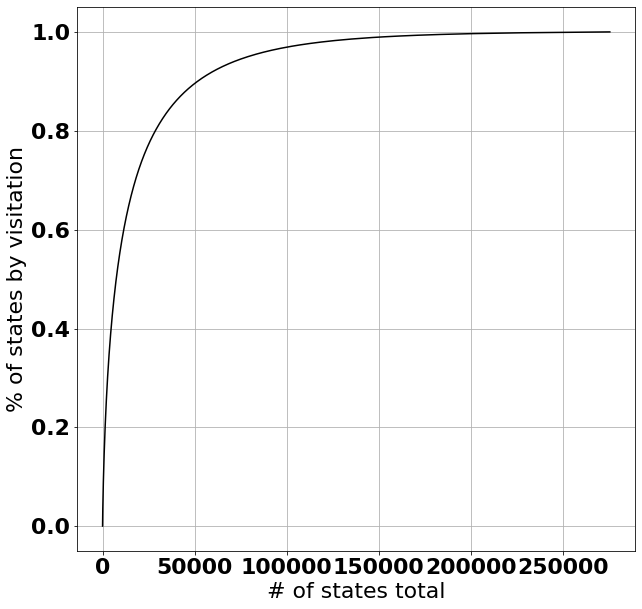

In [198]:
prob_so_far = cum_sums/mass_total

plt.figure(figsize=(10,10))
plt.plot(prob_so_far, color='k')
plt.xlabel('# of states total')
plt.ylabel('% of states by visitation')

plt.grid('both')

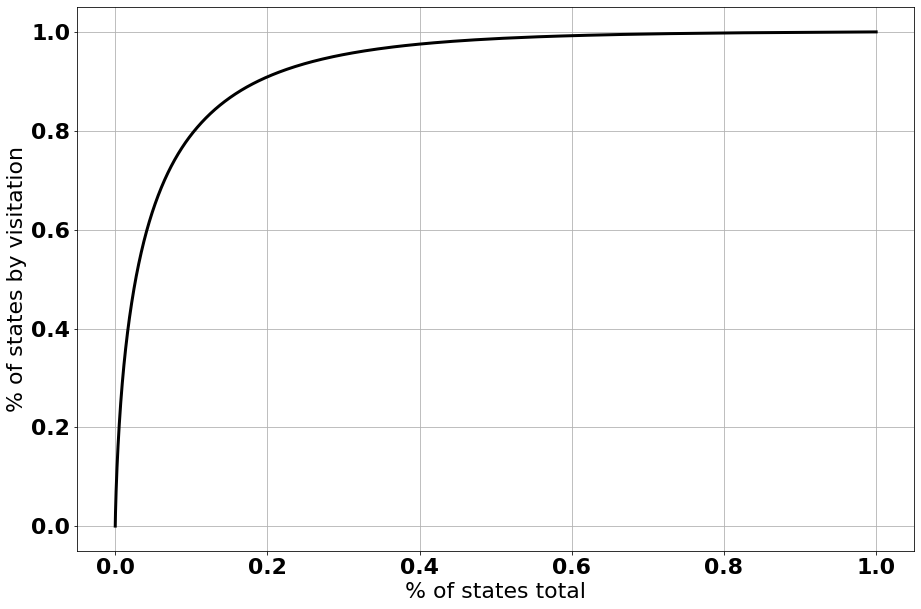

In [202]:
prob_so_far = cum_sums/mass_total
pstates_so_far = np.linspace(0,1,prob_so_far.shape[0])

plt.figure(figsize=(15,10))
plt.plot(pstates_so_far, prob_so_far, color='k',  linewidth=3)
plt.xlabel('% of states total')
plt.ylabel('% of states by visitation')

plt.grid('both')

In [ ]:
plt.plot(pstates_so_far, prob_so_far)
plt.yscale('log')
plt.xscale('log')
plt.grid('minor')

In [146]:
import gym
import torch
import gym
import random
from scipy.signal import find_peaks


env_name = "Hopper-v2"
post_names = ['madodiv', 'mdim_div']

def my_reset(env, point):
    env.reset()
    qpos = np.concatenate((np.array([0.0]), point[:5]))
    qvel = point[5:]
    env.unwrapped.set_state(qpos, qvel)
    return env.unwrapped._get_obs()

def fail_cond(ob):
    #tilted = np.abs(ob[:,1]) > .2 
    short = ob[:,0] < .7
    #return np.logical_or(tilted, short)
    return short


def do_monte_carlo_rollout(arg):
    env, policy = arg
    torch.autograd.set_grad_enabled(False)
    act_list = []
    obs_list = []
    rew_list = []
    x_list = []

    dtype = torch.float32
    init_obs = env.reset()
    done = False
    obs_size = env.observation_space.shape[0]
    act_size = env.action_space.shape[0]

    step_count = 0
    
    while not done:        
        angs = np.random.uniform(0,2*np.pi,1)
        mags = np.random.uniform(0,15,1) 
        force_x = np.cos(angs)*mags
        force_y = np.sin(angs)*mags

        force = (force_x, force_y)
        obs, acts, rews, _ = do_push_rollout_from_state(env, policy, init_obs, force)
        peak_idx,_ = find_peaks(obs[:,0], distance=20)
        
        if len(peak_idx) != 1 or fail_cond(obs[:peak_idx[0]]).any():
            done = True
        else:
            #print(f"step was good, count: {step_count}")
            step_count +=1
            init_obs = obs[peak_idx[0],:]

    torch.autograd.set_grad_enabled(True)
    return step_count


def do_push_rollout_from_state(env, policy, init_state, force, num_steps=100, force_steps = 1, render=False):
    torch.autograd.set_grad_enabled(False)
    act_list = []
    obs_list = []
    rew_list = []
    x_list = []

    dtype = torch.float32
    obs = my_reset(env, init_state)
    done = False
    obs_size = env.observation_space.shape[0]
    act_size = env.action_space.shape[0]

    for cur_step in range(num_steps):
        if render:
            env.render()
            time.sleep(.01)
        
        obs = torch.as_tensor(obs, dtype=dtype).detach()
        #obs += torch.randn(obs_size)*obs_std
        obs_list.append(obs.clone())
        
        x_list.append(env.unwrapped.sim.data.qpos[0])
        
        if cur_step < force_steps:
            env.unwrapped.sim.data.xfrc_applied[1,:] = np.array([force[0],0,force[1],0,0,0])
        else:
            env.unwrapped.sim.data.xfrc_applied[1,:] = np.zeros(6)

        
        act = policy(obs)
        #act += torch.randn(act_size)*act_std
        obs, rew, done, _ = env.step(act.numpy())
        
        act_list.append(torch.as_tensor(act.clone()))
        rew_list.append(rew)
        
    ep_length = len(rew_list)
    ep_obs = torch.stack(obs_list)
    ep_act = torch.stack(act_list)
    ep_rew = torch.tensor(rew_list, dtype=dtype)
    ep_rew = ep_rew.reshape(-1, 1)

    torch.autograd.set_grad_enabled(True)
    return ep_obs, ep_act, ep_rew, x_list


# n_forces = 101

# angs = np.random.uniform(0,2*np.pi,n_forces)
# mags = np.random.uniform(5,15,n_forces) 
# forces_x = np.cos(angs)*mags
# forces_y = np.sin(angs)*mags

# plt.figure(figsize=(8,8))
# plt.polar(angs, mags, 'o',color='k')

# force_iter = [np.array([fx,fy]) for fy,fx in zip(forces_x, forces_y)]


env_name = "Hopper-v2"

env = gym.make(env_name)
data = torch.load(f"./data_noise1/{env_name}.xr")
#data = torch.load(f"./data17/{env_name}.xr")

init_policy_dict = data.policy_dict

data = torch.load(f"./data_noise1_mdim/{env_name}.xr")
#data = torch.load(f"./data_mcshdim4/{env_name}.xr")
policy_dict = data.policy_dict
policy_dict['identity'] = init_policy_dict['identity']
policy_dict['madodiv'] = init_policy_dict['madodiv']

In [147]:
from multiprocessing import Pool
from itertools import repeat
n_trials = 1000
data = []
with Pool(12, maxtasksperchild=1000) as pool:
        env_iter = repeat(env, n_trials)
        pol_iter = repeat(policy_dict['mdim_div'][0])
        for i, res  in enumerate(pool.imap(do_monte_carlo_rollout, zip(env_iter, pol_iter))):
            steps = res
            data.append(steps)

In [131]:
data = np.array(data)

In [132]:
data.sort()

In [133]:
data[int(data.shape[0]/2)]

248

In [134]:
data.std()

350.08507303082774

In [135]:
data.mean()

355.129

In [29]:
data.max()

901

In [109]:
np.percentile??

Signature:
np.percentile(
    a,
    q,
    axis=None,
    out=None,
    overwrite_input=False,
    interpolation='linear',
    keepdims=False,
)
Source:   
@array_function_dispatch(_percentile_dispatcher)
def percentile(a, q, axis=None, out=None,
               overwrite_input=False, interpolation='linear', keepdims=False):
    """
    Compute the q-th percentile of the data along the specified axis.

    Returns the q-th percentile(s) of the array elements.

    Parameters
    ----------
    a : array_like
        Input array or object that can be converted to an array.
    q : array_like of float
        Percentile or sequence of percentiles to compute, which must be between
        0 and 100 inclusive.
    axis : {int, tuple of int, None}, optional
        Axis or axes along which the percentiles are computed. The
        default is to compute the percentile(s) along a flattened
        version of the array.

        .. versionchanged:: 1.9.0
            A tuple of axes is supporte